In [1]:
from __future__ import print_function

import os
import sys

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import nltk

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def add_ngram(txt, n_gram_range = 2):
    """
    data augmentation using n-grams
    input : list of words from tokenized string -> ['ab', 'cdef', 'ghijk']
    output : augmented string to be processed by Keras Tokenizer -> 'ab cdef ghijk ab+cdef cdef+ghijk'
    """
    n_gram = []
    for j in range (1, n_gram_range + 1):
        for i in range(len(txt) - j + 1): 
            n_gram.append('+'.join(txt[i : i + j]))
    return ' '.join(n_gram)

In [141]:
def preprocess(dframe):
    """
    preprocessing of the 'text' field of input dataframe dframe:
    - tokenization
    - data augmentation using add_ngram
    output : returns a list of strings
    """
    texts = list(dframe['text'])
    tokenized_texts = [nltk.tokenize.word_tokenize(texts[i]) for i in range(len(texts))]
    
    augmented_text = []
    for i in range(len(tokenized_texts)):
        augmented_text.append(add_ngram(tokenized_texts[i]))
    return augmented_text

In [4]:
lst = add_ngram(['ab', 'cdef', 'ghijk'], n_gram_range = 1)

In [5]:
lst

'ab cdef ghijk'

### Text training samples and labels

In [6]:
train_df = pd.read_csv('train.csv')

In [7]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [8]:
texts = list(train_df['text'])
texts[np.random.randint(len(train_df))] #random text

'Maddened by the sound, or by the stench which billowed forth even to the open air, the waiting horse gave a scream that was too frantic for a neigh, and plunged madly off through the night, the wagon rattling crazily behind it.'

### Data augmentation using n-grams

In [9]:
augmented = preprocess(train_df)

In [10]:
augmented[np.random.randint(len(augmented))]

'Remember that I am thy creature ; I ought to be thy Adam , but I am rather the fallen angel , whom thou drivest from joy for no misdeed . Remember+that that+I I+am am+thy thy+creature creature+; ;+I I+ought ought+to to+be be+thy thy+Adam Adam+, ,+but but+I I+am am+rather rather+the the+fallen fallen+angel angel+, ,+whom whom+thou thou+drivest drivest+from from+joy joy+for for+no no+misdeed misdeed+.'

In [140]:
len(train_df),len(augmented)

(19579, 19579)

### filter out low-freq words

In [11]:
f_min = 2
tokenizer = Tokenizer(lower=True, filters='')
tokenizer.fit_on_texts(augmented)
num_words = sum([1 for _, word_freq in tokenizer.word_counts.items() if word_freq >= f_min])

In [12]:
num_words #number of words w/ freq >= f_min

75329

### convert to sequences

In [13]:
tokenizer = Tokenizer(num_words=num_words, lower=True, filters='')
tokenizer.fit_on_texts(augmented)
augmented = tokenizer.texts_to_sequences(augmented)

In [14]:
print(augmented[-1])

[17, 2474, 8, 17227, 16808, 34, 14, 3158, 1, 5, 16, 148, 6, 27, 12, 61, 7295, 11, 23, 815, 12, 3, 14840, 4, 37936, 75143, 687, 15526, 11099, 10, 693, 1963, 277, 206, 1056, 6817, 250, 4158, 435, 49767]


### sequence padding

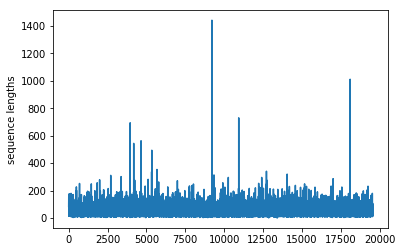

In [16]:
seq_len = [len(augmented[i]) for i in range(len(augmented))]

plt.plot(seq_len)
plt.ylabel('sequence lengths')
plt.show()

In [17]:
maxlen = 256
augmented = pad_sequences(sequences=augmented, maxlen=maxlen)
vocab_size = np.max(augmented) + 1

In [18]:
vocab_size

75329

### labelling data

In [20]:
labels_index = {'EAP':0, 'HPL':1, 'MWS':2}
labels = train_df['author'].apply(lambda x:labels_index[x])
y_data = to_categorical(labels)

In [21]:
len(y_data), len(augmented)

(19579, 19579)

In [26]:
x_train, x_val, y_train, y_val = train_test_split(augmented, y_data, test_size=0.2, random_state=42)


### Model

In [52]:
embedding_dims = 20

model = Sequential()

model.add(Embedding(vocab_size, embedding_dims))#, input_length=maxlen))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [53]:
hist = model.fit(x_train, y_train,
                batch_size=32,
                epochs=10,
                validation_data=(x_val, y_val),
                callbacks=[EarlyStopping(patience=1, monitor='val_loss')])

Train on 15663 samples, validate on 3916 samples
Epoch 1/10
15663/15663 [==============================] - 10s - loss: 1.0754 - acc: 0.4046 - val_loss: 1.0576 - val_acc: 0.4019
Epoch 2/10
15663/15663 [==============================] - 10s - loss: 1.0060 - acc: 0.4654 - val_loss: 0.9641 - val_acc: 0.5975
Epoch 3/10
15663/15663 [==============================] - 10s - loss: 0.8733 - acc: 0.6978 - val_loss: 0.8396 - val_acc: 0.7168
Epoch 4/10
15663/15663 [==============================] - 10s - loss: 0.7318 - acc: 0.7979 - val_loss: 0.7418 - val_acc: 0.7252
Epoch 5/10
15663/15663 [==============================] - 10s - loss: 0.6143 - acc: 0.8371 - val_loss: 0.6528 - val_acc: 0.7735
Epoch 6/10
15663/15663 [==============================] - 10s - loss: 0.5228 - acc: 0.8662 - val_loss: 0.5938 - val_acc: 0.7860
Epoch 7/10
15663/15663 [==============================] - 10s - loss: 0.4504 - acc: 0.8865 - val_loss: 0.5482 - val_acc: 0.8090
Epoch 8/10
15663/15663 [==============================]

In [60]:
hist = model.fit(x_train, y_train, #repeat 6-7times
                batch_size=16,
                epochs=1,
                validation_data=(x_val, y_val))

Train on 15663 samples, validate on 3916 samples
Epoch 1/1
15663/15663 [==============================] - 19s - loss: 0.0787 - acc: 0.9857 - val_loss: 0.3382 - val_acc: 0.8685


In [61]:
model.save_weights('V4.h5')

In [63]:
hist = model.fit(x_train, y_train,
                batch_size=16,
                epochs=1,
                validation_data=(x_val, y_val))

Train on 15663 samples, validate on 3916 samples
Epoch 1/1
15663/15663 [==============================] - 19s - loss: 0.0544 - acc: 0.9913 - val_loss: 0.3353 - val_acc: 0.8726


In [64]:
model.save_weights('V4.h5')

In [67]:
model.load_weights('V4.h5')

### Predictions

In [68]:
test_df = pd.read_csv('test.csv')

In [127]:
test_df.shape

(8392, 2)

In [142]:
augmented_test = preprocess(test_df)

In [143]:
len(augmented_test)

8392

In [144]:
augmented_test = tokenizer.texts_to_sequences(augmented_test)

In [145]:
augmented_test = pad_sequences(sequences=augmented_test, maxlen=maxlen)

In [146]:
y = model.predict_proba(augmented_test)

6816/8392 [=======================>......] - ETA: 0s

In [147]:
y.shape

(8392, 3)

In [148]:
np.clip(a=y, a_min=0.005, a_max=0.995)

array([[ 0.02601475,  0.005     ,  0.97124994],
       [ 0.995     ,  0.005     ,  0.005     ],
       [ 0.005     ,  0.995     ,  0.005     ],
       ..., 
       [ 0.84793144,  0.07023995,  0.08182856],
       [ 0.17498884,  0.005     ,  0.82088482],
       [ 0.07569077,  0.92429769,  0.005     ]], dtype=float32)

In [149]:
result_df = pd.read_csv('sample_submission.csv')

In [150]:
def write_subm_file(clip_value = 0):
    id_df = pd.DataFrame(result_df['id'])
    probs_df = pd.DataFrame(np.clip(a = y, a_min = clip_value, a_max = 1 - clip_value))
    subm_df = pd.concat([id_df, probs_df], axis = 1)
    header = sorted(labels_index.keys())
    header.insert(0,'id')
    subm_df.columns = header
    subm_df.to_csv('submission_' + str(clip_value) + '.csv', sep=',', index = False, float_format = '%.17f')

In [151]:
write_subm_file()

In [155]:
write_subm_file(0.0001)

In [154]:
write_subm_file(0.001)